In [17]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


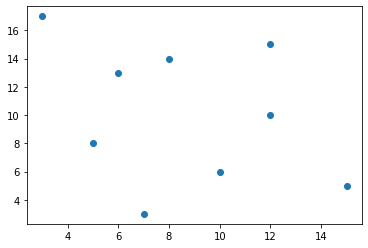

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from random import shuffle
import copy
env_size = 20

# start = np.array([1, 1])
starts = np.array([
    [1, 1], [env_size - 1, env_size - 1], [1, env_size - 1], [env_size - 1, 1],
    [1, env_size / 2], [env_size / 2, 1], [env_size - 1, env_size / 2], [env_size / 2, env_size - 1]
])
goal = np.array([10, 10])
q = defaultdict(lambda: 0)
buffer = set()
actions = np.array([[-1,0],[0,-1],[0,1],[1,0]])
obstacles = np.array([
    [15, 5],
    [5, 8],
    [3, 17],
    [12, 15],
    [7, 3],
    [6., 13],
    [10., 6],
    [8, 14],
    [12, 10]
])

plt.scatter(obstacles[:, 0], obstacles[:, 1])

In [19]:
def sample_start_on_boundary():
    if np.random.uniform(0, 1) < 0.5:
        x = np.random.choice([1, env_size - 1])
        y = np.random.randint(1, env_size)
    else:
        y = np.random.choice([1, env_size - 1])
        x = np.random.randint(1, env_size)
    return np.array([x, y])

sample_start_on_boundary()

array([3, 1])

In [20]:
def learn_q():
    listbuffer = list(buffer)
    shuffle(listbuffer)
    for data in listbuffer:
        s, a, s_next, reward, done = data
        if done:
            q[s, a] = q[s, a] + 0.1 * (reward - q[s, a])
        else:
            v_next = max([q[s_next, tuple(a_)] for a_ in actions])
            q[s, a] = q[s, a] + 0.1 * (reward + v_next - q[s, a])

In [21]:
q = defaultdict(lambda: 0)
buffer = set()
reached = 0
max_iter = 2000
initial_eps = .65
final_eps = 0.05
for num_iter in tqdm(range(max_iter)):
#     state = start.copy()
    state = sample_start_on_boundary()
#     if np.random.rand() < 0.5:
#         selected_start_id = np.random.randint(starts.shape[0])
#         state = starts[selected_start_id].copy()
# #         state = start.copy()
#     else:
#         state = np.random.randint(1, env_size, [2])
#         print (state)
    eps = initial_eps + (final_eps - initial_eps) * num_iter / float(max_iter)
#     print (eps)
    for _ in range(100):
        if np.random.rand() < eps:
            action = actions[np.random.choice(np.arange(len(actions)))]
        else:
            q_values = np.array([q[tuple(state), tuple(a)] for a in actions])
            action = actions[np.random.choice(np.arange(len(actions))[q_values==q_values.max()])]
        state_next = state + action
#         state_next = state_next.clip(0, env_size)
        done = (state_next==goal).all()
        reward = np.linalg.norm(state-goal)-np.linalg.norm(state_next-goal)
        min_distance2obstacles = min(np.linalg.norm(obstacles - state_next, axis = 1))
        if 0 in state_next or env_size in state_next or min_distance2obstacles == 0.:
            done = True 
            reward = 0
#             reward = -5.
        
        buffer.add((tuple(state), tuple(action), tuple(state_next), reward, done))
        state = state_next
        if done:
            if (state_next==goal).all():
                reached += 1
            break
#     print (state)
    learn_q()

reached

100%|██████████| 2000/2000 [00:10<00:00, 192.81it/s]


1206

In [22]:
import json

q_str = {}
for k in q:
    q_str[str(k)] = copy.deepcopy(q[k])

with open("0217_grid_Q.json2", "w") as outfile:
    json.dump(q_str, outfile)

In [23]:
import json 

with open("0217_grid_Q.json2") as infile:
    q = json.load(infile)

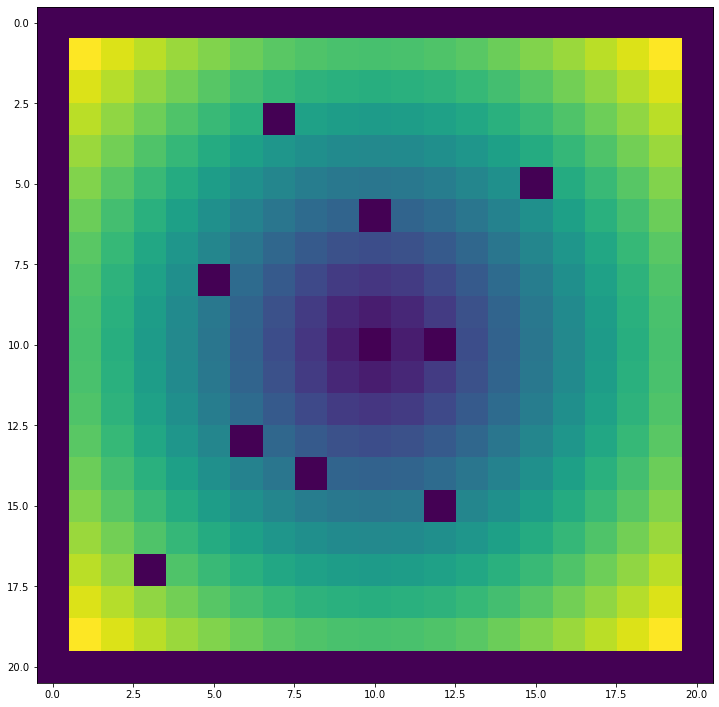

In [24]:
xs = np.arange(env_size+1)
ys = np.arange(env_size+1)
xx, yy = np.meshgrid(xs, ys)

value = []
for x, y in zip(xx.reshape(-1), yy.reshape(-1)):
    value.append(np.array([q.get(str(((x, y), tuple(a))), 0.) for a in actions]).max())

plt.clf()
plt.cla()
plt.close('all')

value = np.array(value).reshape(xx.shape)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(value)

# Loop over data dimensions and create text annotations.
# for i in xs:
#     for j in ys:
#         text = ax.text(j, i, '%.f' % value[i,j], ha="center", va="center", color="w", fontsize=8)

fig.tight_layout()
plt.show()

In [25]:
import itertools

state_space = list(itertools.product(np.arange(1, env_size, 1),
                                     np.arange(1, env_size, 1)))

def convert_to_V_from_Q():
    V = defaultdict(lambda: 0)
    for state in state_space:
        V[tuple(state)] = max([q.get(str((tuple(state), tuple(ac))), 0.) for ac in actions])
    return V

def learn_CLF_from_Q(low_margin = 0.1):
    # push the landscape based on optimal controls from Q 
    V = convert_to_V_from_Q()
    CLF_V = copy.deepcopy(V)
    for state in state_space:
        # compute V(s) - max_{a} V(s'| s, a)
        next_states = copy.deepcopy(state + actions)
        vals = [V.get(tuple(next_state), 0) for next_state in next_states]
        best_ac_id = np.argmin(vals) # no need to worry about tie 
        next_state, next_val = copy.deepcopy(state + actions[best_ac_id]), vals[best_ac_id]
        val_diff = V.get(tuple(state), 0) - next_val
        
        if val_diff < low_margin:
            # want to increase the difference to at least low_margin
            change = low_margin - val_diff 
            # need to add change to all V(s' | s, a)
            # to keep the same control preference at s 
            
            # also, need to ensure the preference at prior states of s 

V = convert_to_V_from_Q()
# V

In [35]:
state_space = np.array(list(itertools.product(np.arange(1, env_size, 1),
                                     np.arange(1, env_size, 1))))

all_relative_states = copy.deepcopy(state_space) - goal
all_l0_distances = np.sum(np.abs(all_relative_states), axis = 1)
ranks = np.sort(np.unique(all_l0_distances))[::-1]

grouped_states = []
for depth in ranks:
    grouped_states.append(copy.deepcopy(state_space[np.where(all_l0_distances == depth)[0]]))

CLF_V = defaultdict(lambda: 0)
margin = 0.5

delta = 0
for group_id in range(len(grouped_states)-1):
    vals_to_add = 0. # for next group_id
    states = grouped_states[group_id]
    print(delta)
    for state in states:
        CLF_V[tuple(state)] = V[tuple(state)]
        if group_id != 0:
            CLF_V[tuple(state)] += delta
    delta = 0

    next_group_states = grouped_states[group_id + 1]
    for state in states:
        next_states = copy.deepcopy(state + actions)
        next_states_in_next_group = []
        for next_state in next_states:
            if (np.all(next_group_states == next_state, axis = 1)).any():
                next_states_in_next_group.append(next_state)
        values = [V[tuple(s)] for s in next_states_in_next_group]
        val_diff = max(values) - CLF_V[tuple(state)]
        if val_diff < margin:
            delta = max(delta, margin - val_diff)


group_id = len(grouped_states) - 1 
states = grouped_states[group_id]
print (delta)
for state in states:
    CLF_V[tuple(state)] = V[tuple(state)] 
    if group_id != 0:
        CLF_V[tuple(state)] += delta 

0
1.1863274825655523
2.32616781036646
3.5097304966165623
4.639876309351205
5.819826788669975
6.937045978920228
8.112077677252136
9.4632328746227
10.631176449055324
12.131176449055317
13.631176449055314
15.13117644905531
16.631176449055307
22.13117644905529
23.631176449055285
27.13117644905528
28.63117644905528
30.13117644905528


In [11]:
for group_id in range(len(grouped_states)-1):
    print ("group id: {}".format(group_id))
    states = grouped_states[group_id]
    for state in states:
        print ("\t {}, {}".format(state, CLF_V[tuple(state)]))
    print ("")

group id: 0
	 [1 1], 12.727922061357773
	 [ 1 19], 12.72792206135777
	 [19  1], 12.72792206135777
	 [19 19], 12.727922061357773

group id: 1
	 [1 2], 13.227922061357773
	 [ 1 18], 13.22792206135777
	 [2 1], 13.227922061357773
	 [ 2 19], 13.22792206135777
	 [18  1], 13.22792206135777
	 [18 19], 13.227922061357773
	 [19  2], 13.22792206135777
	 [19 18], 13.227922061357773

group id: 2
	 [1 3], 13.727922061357777
	 [ 1 17], 13.727922061357773
	 [2 2], 13.639876309351159
	 [ 2 18], 13.639876309351155
	 [3 1], 13.727922061357777
	 [ 3 19], 13.72792206135777
	 [17  1], 13.727922061357773
	 [17 19], 13.727922061357777
	 [18  2], 13.639876309351155
	 [18 18], 13.639876309351159
	 [19  3], 13.727922061357773
	 [19 17], 13.727922061357777

group id: 3
	 [1 4], 14.326384323008476
	 [ 1 16], 14.326384323008472
	 [2 3], 14.139876309351159
	 [ 2 17], 14.139876309351155
	 [3 2], 14.139876309351159
	 [ 3 18], 14.139876309351152
	 [4 1], 14.326384323008476
	 [ 4 19], 14.326384323008469
	 [16  1], 14.32

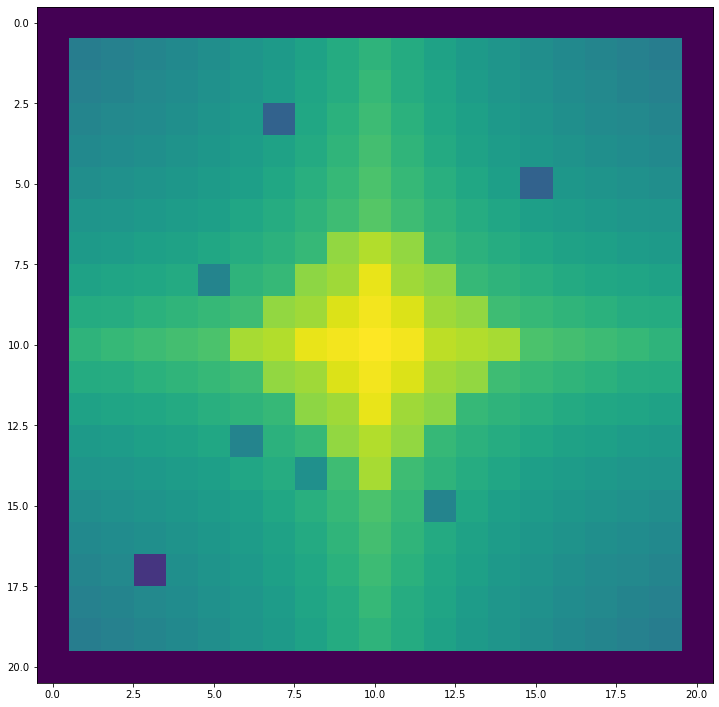

In [36]:
xs = np.arange(env_size+1)
ys = np.arange(env_size+1)
xx, yy = np.meshgrid(xs, ys)

value = []
for x, y in zip(xx.reshape(-1), yy.reshape(-1)):
    value.append(CLF_V[tuple([x, y])])

plt.clf()
plt.cla()
plt.close('all')

value = np.array(value).reshape(xx.shape)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(value)

# Loop over data dimensions and create text annotations.
# for i in xs:
#     for j in ys:
#         text = ax.text(j, i, '%.f' % value[i,j], ha="center", va="center", color="w", fontsize=8)

fig.tight_layout()
plt.show()

In [53]:
def verify_CLF(values,
               goal_state,
               min_margin = 0.1):
    for state in state_space:
        next_states = copy.deepcopy(state + actions)
        best_next_val = min([values[tuple(next_state)] for next_state in next_states])
        diff = values[tuple(state)] - best_next_val
        if (state != goal_state).all() and diff <= min_margin:
            print ("invalid!!! ", state, values[tuple(state)], next_states, best_next_val)
    all_vals = list(values.values()) 
    goal_val = values[tuple(goal_state)]
    if min(all_vals) != goal_val:
        print ("goal not the lowest")
        
verify_CLF(V, goal)

invalid!!!  (3, 17) 0.0 [[ 2 17]
 [ 3 16]
 [ 3 18]
 [ 4 17]] 9.219544457292841
invalid!!!  (5, 8) 0.0 [[4 8]
 [5 7]
 [5 9]
 [6 8]] 4.472135954999569
invalid!!!  (6, 13) 0.0 [[ 5 13]
 [ 6 12]
 [ 6 14]
 [ 7 13]] 4.242640687119273
invalid!!!  (7, 3) 0.0 [[6 3]
 [7 2]
 [7 4]
 [8 3]] 6.708203932499348
invalid!!!  (8, 14) 0.0 [[ 7 14]
 [ 8 13]
 [ 8 15]
 [ 9 14]] 3.6055512754639816
invalid!!!  (12, 15) 0.0 [[11 15]
 [12 14]
 [12 16]
 [13 15]] 4.472135954999569
invalid!!!  (15, 5) 0.0 [[14  5]
 [15  4]
 [15  6]
 [16  5]] 6.403124237432827


In [13]:
use_V = True

x = np.array([19, 1])#copy.deepcopy(start)
for _ in range(500):
    if use_V:
        next_states = copy.deepcopy(x + actions)
        temp = [CLF_V[tuple(next_state)] for next_state in next_states]
#         print (next_states, temp)
    else:
        temp = [q[str((tuple(x), tuple(actions[i])))] for i in range(len(actions))]
#     print (temp)
    print (max(temp))
    ac_id = np.argmax([q[str((tuple(x), tuple(actions[i])))] for i in range(len(actions))])
    action = copy.deepcopy(actions[ac_id]) 
#     x = (x + action).clip(1, env_size - 1) 
    x += action 
    min_distance2obstacles = min(np.linalg.norm(obstacles - x, axis = 1))
    if 0 in x or env_size in x or min_distance2obstacles == 0.:
        break
#     print (x)
    if x[0] == goal[0] and x[1] == goal[1]:
        break
x

13.22792206135777
13.727922061357773
14.326384323008472
14.935506450338156
15.668684590466036
16.423878959425327
16.656081422569635
17.079005980486592
17.911286338335827
18.455731769392067
19.01634125618981
19.603312404054886
20.754282074672965
25.29345410922367
26.63117644905529
29.131176449055285
29.631176449055285
29.131176449055285


array([10, 10])

In [14]:
CLF_V

defaultdict(<function __main__.<lambda>()>,
            {(1, 1): 12.727922061357773,
             (1, 19): 12.72792206135777,
             (19, 1): 12.72792206135777,
             (19, 19): 12.727922061357773,
             (1, 2): 13.227922061357773,
             (1, 18): 13.22792206135777,
             (2, 1): 13.227922061357773,
             (2, 19): 13.22792206135777,
             (18, 1): 13.22792206135777,
             (18, 19): 13.227922061357773,
             (19, 2): 13.22792206135777,
             (19, 18): 13.227922061357773,
             (1, 3): 13.727922061357777,
             (1, 17): 13.727922061357773,
             (2, 2): 13.639876309351159,
             (2, 18): 13.639876309351155,
             (3, 1): 13.727922061357777,
             (3, 19): 13.72792206135777,
             (17, 1): 13.727922061357773,
             (17, 19): 13.727922061357777,
             (18, 2): 13.639876309351155,
             (18, 18): 13.639876309351159,
             (19, 3): 13.727922061357773

In [90]:
import itertools
state_space = list(itertools.product(np.arange(1, env_size, 1),
                                     np.arange(1, env_size, 1)))

s = state_space[0]
q[str((tuple(s), tuple(actions[0])))]

0.0

In [9]:
from CLF import *

import itertools

In [12]:
# learn CLF from well-trained Q.
# for now, we construct the entire opt/nopt sets 

state_space = list(itertools.product(np.arange(1, env_size, 1),
                                     np.arange(1, env_size, 1)))

opt_states, opt_nstates, opt_acs, nopt_states, nopt_nstates, nopt_acs = [], [], [], [], [], []
all_q_vals, all_rewards = {}, {}
all_states = {}
# all_states, all_nstates, all_acs = [], [], []

for state in state_space:
    q_vals = [q.get(str((tuple(state), tuple(actions[i]))), 0.) for i in range(len(actions))]
    if sum(q_vals) == 0: # ignore the unvisited states
        continue
    q_vals = np.array(q_vals)
#     print (q_vals)
    best_ac_ids = np.where(q_vals == max(q_vals))[0]
#     print (best_ac_ids)
    processed_state = convert_polar_coordinates([state])[0]
    all_states[tuple(processed_state)] = []
    all_q_vals[tuple(processed_state)] = []
    all_rewards[tuple(processed_state)] = []
    
    for ac_id in range(len(actions)):
        ac = actions[ac_id]
        state_next = state + ac
#         state_next = state_next.clip(1, env_size - 1)
        if ac_id in best_ac_ids:
#             if state_next[0] < state[0] or state_next[1] < state[1]:
#                 continue
            opt_states.append(copy.deepcopy(state))
            opt_nstates.append(copy.deepcopy(state_next))   
            opt_acs.append(copy.deepcopy(ac))
        else:
            nopt_states.append(copy.deepcopy(state))
            nopt_nstates.append(copy.deepcopy(state_next)) 
            nopt_acs.append(copy.deepcopy(ac))
            
#         all_states.append(copy.deepcopy(state))
        all_states[tuple(processed_state)].append(copy.deepcopy(convert_polar_coordinates([state_next])[0])) 
        all_q_vals[tuple(processed_state)].append(copy.deepcopy(q.get(str((tuple(state), tuple(ac))), 0.))) 
        reward = np.linalg.norm(state - goal) - np.linalg.norm(state_next - goal)
        all_rewards[tuple(processed_state)].append(copy.deepcopy(reward))

goal_copied = copy.deepcopy(goal)
data = [convert_polar_coordinates(np.array(opt_states)), convert_polar_coordinates(np.array(opt_nstates)), convert_polar_coordinates(np.array(nopt_states)), convert_polar_coordinates(np.array(nopt_nstates))]
# data = [np.array(opt_states), np.array(opt_nstates), np.array(all_nstates), np.array(all_q_vals), np.array(all_rewards)]
# processed_all_states = {k:convert_polar_coordinates(all_states[k]) for k in all_states}

data = [convert_polar_coordinates(np.array(opt_states)), 
        convert_polar_coordinates(np.array(opt_nstates)), 
        all_states, all_q_vals, all_rewards]
# _ = [print(d.shape) for d in data]
len(all_states)

360

In [152]:
data[0][:5], data[1][:5]

(array([[12.72792206,  3.92699082],
        [12.72792206,  3.92699082],
        [12.04159458,  3.86823499],
        [12.04159458,  3.86823499],
        [11.40175425,  3.80263582]]),
 array([[12.04159458,  3.86823499],
        [12.04159458,  3.98574664],
        [11.40175425,  3.80263582],
        [11.3137085 ,  3.92699082],
        [10.81665383,  3.72959526]]))

In [11]:
def convert_polar_coordinates(positions):
    temp = positions - goal
    distances = np.linalg.norm(positions - goal, axis = 1)
    ang = np.arctan2(temp[:, 1], temp[:, 0]) #/ np.pi 
    ang[np.where(ang < 0)] += 2. * np.pi
    return np.hstack([distances.reshape([-1, 1]), ang.reshape([-1, 1])])

temp = convert_polar_coordinates(opt_states)
temp

ValueError: operands could not be broadcast together with shapes (0,) (2,) 

In [46]:
i = -23

data[0][i], data[1][i]

(array([49, 34]), array([48, 34]))

In [33]:
margin = 0.1
num_iters = 2000
verbose_iter = 50
lr = 1e-4

from CLF import *

model = NCLF(2, [64, 64])
model.compile(Adam(lr = lr))
model.fit(data, 
          train_w_properties = False,
          margin = margin,
          num_iters = num_iters,
          verbose_iter = verbose_iter)

iter 0: (1.6428702, 0.31250134, 1.3303689)
iter 50: (1.48414, 0.028323723, 1.4558163)
iter 100: (1.5045608, 0.014263217, 1.4902976)
iter 150: (1.5099689, 0.012709077, 1.4972599)
iter 200: (1.5163834, 0.012572769, 1.5038106)
iter 250: (1.5231669, 0.012458873, 1.510708)
iter 300: (1.5305334, 0.012344999, 1.5181885)
iter 350: (1.5384904, 0.012227198, 1.5262632)
iter 400: (1.5473439, 0.01209859, 1.5352453)
iter 450: (1.5571249, 0.01195808, 1.5451667)
iter 500: (1.567883, 0.011806922, 1.556076)
iter 550: (1.579229, 0.011659524, 1.5675695)
iter 600: (1.5880837, 0.011581253, 1.5765024)
iter 650: (1.5966172, 0.011512984, 1.5851042)
iter 700: (1.6036032, 0.011471042, 1.5921322)
iter 750: (1.6101218, 0.01143643, 1.5986854)
iter 800: (1.616916, 0.01140247, 1.6055135)
iter 850: (1.6232017, 0.011375645, 1.6118261)
iter 900: (1.628855, 0.011354808, 1.6175002)
iter 950: (1.6347545, 0.011333308, 1.6234212)
iter 1000: (1.6409824, 0.011310789, 1.6296716)
iter 1050: (1.6475543, 0.011287227, 1.6362671)
it

KeyboardInterrupt: 

In [36]:
model.model.save_weights("./0215_NCLF_model_3")
# # model.model.load_weights("./0212_NCLF_model")

In [55]:
data[0][:10], data[1][:10]

(array([[-24, -24],
        [-24, -24],
        [-24, -23],
        [-24, -22],
        [-24, -22],
        [-24, -21],
        [-24, -21],
        [-24, -20],
        [-24, -20],
        [-24, -19]]),
 array([[-24, -23],
        [-23, -24],
        [-23, -23],
        [-24, -21],
        [-23, -22],
        [-24, -20],
        [-23, -21],
        [-24, -19],
        [-23, -20],
        [-23, -19]]))

In [67]:
x = [29, 26]

q_vals = [q.get(str((tuple(x), tuple(actions[i]))), 0) for i in range(len(actions))]
q_vals = np.array(q_vals)
best_ac_ids = np.where(q_vals == max(q_vals))[0]
    
for ac in actions:
    print (ac, q.get(str((tuple(x), tuple(ac))), 0))
best_ac_ids

[-1  0] 4.123105625617651
[ 0 -1] 4.123105625617651
[0 1] 4.1231056256176455
[1 0] 4.123105625617644


array([0, 1])

In [17]:
opt_vals = model.predict(convert_polar_coordinates(np.array(opt_states)).astype(np.float))
opt_nvals = model.predict(convert_polar_coordinates(np.array(opt_nstates)).astype(np.float))

num_violations = 0
for i in range(len(opt_vals)):
    val, nval = opt_vals[i], opt_nvals[i]
    if nval - val < margin:
        print ("opt_state: ", data[0][i])
        print ("opt_nstate: ", data[1][i])
        print (val, nval, nval - val, margin)
        print ("")
        num_violations += 1

opt_state:  [9.05538514 3.25224987]
opt_nstate:  [9.         3.14159265]
[-5.6341558] [-5.5989532] [0.0352025] 0.1

opt_state:  [9.05538514 3.03093543]
opt_nstate:  [9.         3.14159265]
[-5.6323447] [-5.5989532] [0.03339148] 0.1

opt_state:  [8.06225775 3.26594765]
opt_nstate:  [8.         3.14159265]
[-5.0192723] [-4.979703] [0.03956938] 0.1

opt_state:  [8.06225775 3.01723766]
opt_nstate:  [8.         3.14159265]
[-5.0172386] [-4.979703] [0.03753567] 0.1

opt_state:  [7.07106781 3.28348971]
opt_nstate:  [7.         3.14159265]
[-4.4056225] [-4.3604517] [0.04517078] 0.1

opt_state:  [7.07106781 2.9996956 ]
opt_nstate:  [7.         3.14159265]
[-4.4033003] [-4.3604517] [0.04284859] 0.1

opt_state:  [6.08276253 3.30674133]
opt_nstate:  [6.         3.14159265]
[-3.793804] [-3.7412019] [0.05260205] 0.1

opt_state:  [6.08276253 2.97644398]
opt_nstate:  [6.         3.14159265]
[-3.7911022] [-3.7412019] [0.04990029] 0.1

opt_state:  [5.09901951 3.33898821]
opt_nstate:  [5.         3.14159

/home/jeff/anaconda3/envs/NCLF/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/jeff/anaconda3/envs/NCLF/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [18]:
tf.reduce_mean(tf.nn.relu(margin - (opt_nvals - opt_vals)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.011148688>

In [19]:
num_violations, len(opt_vals)

(54, 491)

In [22]:
nopt_vals = model.predict(convert_polar_coordinates(np.array(nopt_states)).astype(np.float))
nopt_nvals = model.predict(convert_polar_coordinates(np.array(nopt_nstates)).astype(np.float))

num_violations = 0
for i in range(len(nopt_vals)):
    val, nval = nopt_vals[i], nopt_nvals[i]
    if nval - val > margin:
        print ("nopt_state: ", nopt_states[i])
        print ("nopt_nstate: ", nopt_nstates[i])
        print (val, nval, nval - val, margin)
        print ("")
        num_violations += 1

nopt_state:  (1, 4)
nopt_nstate:  [1 5]
[-6.7287273] [-6.4054203] [0.32330704] 0.1

nopt_state:  (1, 6)
nopt_nstate:  [1 7]
[-6.12803] [-5.903056] [0.22497368] 0.1

nopt_state:  (1, 7)
nopt_nstate:  [1 8]
[-5.903056] [-5.736695] [0.16636133] 0.1

nopt_state:  (1, 8)
nopt_nstate:  [1 9]
[-5.736695] [-5.6341558] [0.10253906] 0.1

nopt_state:  (1, 12)
nopt_nstate:  [ 1 11]
[-5.7331166] [-5.6323447] [0.1007719] 0.1

nopt_state:  (1, 13)
nopt_nstate:  [ 1 12]
[-5.897792] [-5.7331166] [0.16467524] 0.1

nopt_state:  (1, 14)
nopt_nstate:  [ 1 13]
[-6.1211877] [-5.897792] [0.22339582] 0.1

nopt_state:  (1, 16)
nopt_nstate:  [ 1 15]
[-6.7191067] [-6.3971243] [0.32198238] 0.1

nopt_state:  (2, 3)
nopt_nstate:  [3 3]
[-6.6143026] [-6.1623907] [0.45191193] 0.1

nopt_state:  (2, 4)
nopt_nstate:  [2 5]
[-6.2234664] [-5.872266] [0.35120058] 0.1

nopt_state:  (2, 5)
nopt_nstate:  [2 6]
[-5.872266] [-5.5682364] [0.30402946] 0.1

nopt_state:  (2, 6)
nopt_nstate:  [2 7]
[-5.5682364] [-5.319511] [0.2487254

/home/jeff/anaconda3/envs/NCLF/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/jeff/anaconda3/envs/NCLF/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [19]:
num_violations, len(nopt_states)

(1091, 8829)

In [23]:
def get_control_NCLF(x):
    actions_ = copy.deepcopy(actions)
    nxs = x + actions_ 
#     nxs = np.clip(nxs, 1, env_size - 1)
    nvals = model.predict(convert_polar_coordinates(nxs))
#     print (nvals)
    
    good_acs = np.where(nvals == max(nvals))[0]
#     print (good_acs)
    return np.random.choice(good_acs)

In [24]:
x = np.array([15, 15])
ac_id = get_control_NCLF(x)
ac_id, actions[ac_id]

(1, array([ 0, -1]))

In [37]:
x = np.array([10, 1])#copy.deepcopy(start)
# print (x)
for _ in range(500):
#     actions_ = copy.deepcopy(actions)
#     nxs = x + actions_ 
#     nxs = np.clip(nxs, 0, env_size - 1)
#     nvals = model.predict(nxs)
    ac_id = get_control_NCLF(x)
    
#     temp = [q[tuple(x), tuple(actions[i])] for i in range(len(actions))]
#     print (temp)
#     ac_id = np.argmax([q[tuple(x), tuple(actions[i])] for i in range(len(actions))])
    action = copy.deepcopy(actions[ac_id]) 
#     print (action)
#     print (x, action)
    x += action
#     x = (x + action).clip(1, env_size - 1) 
    if 0 in x or env_size in x:
        break
#     print (x)
    if x[0] == goal[0] and x[1] == goal[1]:
        break
x

array([10, 10])

In [24]:
goal

array([25, 25])

In [23]:
def generate_NCLF_sets_from_model(model, tolerance_threshold = 0.005):

    states = copy.deepcopy(state_space)
    all_states = np.repeat(states, len(actions), axis = 0)
    all_next_states = np.vstack([copy.deepcopy(actions + state).clip(0, env_size - 1) for state in states])
    assert all_states.shape == all_next_states.shape
    all_vals = model.predict(all_next_states)
    vals_per_state = all_vals.reshape([-1, len(actions)])
    indices = np.arange(vals_per_state.shape[0] * (len(actions))).reshape(vals_per_state.shape)
    opt_indices = np.concatenate([indices_[np.where(np.abs(vals_ - max(vals_)) < tolerance_threshold)] for indices_, vals_ in zip(indices, vals_per_state)])
    nopt_indices = np.concatenate([indices_[np.where(np.abs(vals_ - max(vals_)) >= tolerance_threshold)] for indices_, vals_ in zip(indices, vals_per_state)])

    opt_states = copy.deepcopy(all_states[opt_indices])
    opt_nstates = copy.deepcopy(all_next_states[opt_indices])
    nopt_states = copy.deepcopy(all_states[nopt_indices])
    nopt_nstates = copy.deepcopy(all_next_states[nopt_indices])
    
    data = [np.array(opt_states), np.array(opt_nstates), np.array(nopt_states), np.array(nopt_nstates)]
    return data 

data = generate_NCLF_sets_from_model(model) 
_ = [print(d.shape) for d in data]

(4707, 2)
(4707, 2)
(7298, 2)
(7298, 2)


In [29]:
margin = .5
num_iters = 100
verbose_iter = 50
lr = 1e-4

model = NCLF(2, [64, 64])
model.compile(Adam(lr = lr))

for epoch in range(100):
    data = generate_NCLF_sets_from_model(model) 
    model.fit(data, margin = margin,
          num_iters = num_iters,
          verbose_iter = verbose_iter)
    print ("----------epoch {} finish--------\n".format(epoch))

iter 0: (0.3691751, 0.3691751, 0.0)
iter 50: (0.0096059125, 0.0096059125, 0.0)
----------epoch 0 finish--------

iter 0: (0.0010982308, 0.0, 0.0010982308)
iter 50: (0.0018060536, 0.0, 0.0018060536)
----------epoch 1 finish--------

iter 0: (0.0019431035, 0.0019431035, 0.0)
iter 50: (0.0027232708, 0.0027232708, 0.0)
----------epoch 2 finish--------

iter 0: (0.00093334983, 0.0, 0.00093334983)
iter 50: (0.0016262105, 0.0, 0.0016262105)
----------epoch 3 finish--------

iter 0: (0.002113038, 0.002113038, 0.0)
iter 50: (0.0028889813, 0.0028889813, 0.0)
----------epoch 4 finish--------

iter 0: (0.0007649011, 0.0, 0.0007649011)
iter 50: (0.00145814, 0.0, 0.00145814)
----------epoch 5 finish--------

iter 0: (0.0022759177, 0.0022759177, 0.0)
iter 50: (0.0030505976, 0.0030505976, 0.0)
----------epoch 6 finish--------

iter 0: (0.00063516595, 0.0, 0.00063516595)
iter 50: (0.0014791221, 0.0, 0.0014791221)
----------epoch 7 finish--------

iter 0: (0.0022438958, 0.0022438958, 0.0)
iter 50: (0.00

KeyboardInterrupt: 